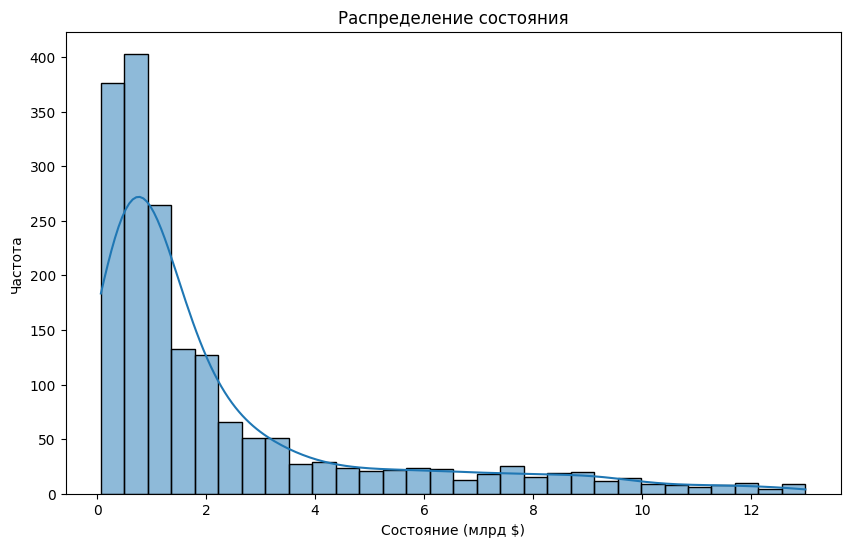

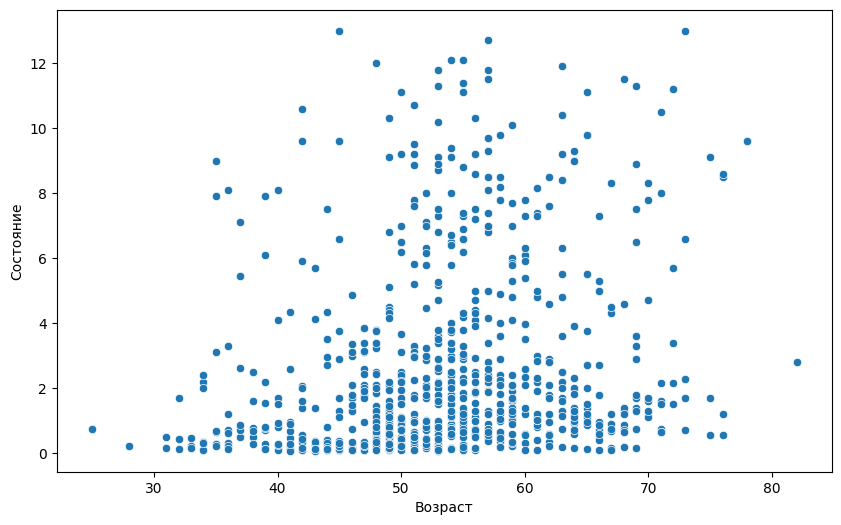

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("all_updated.csv")
Q1 = df["net_worth"].quantile(0.25)
Q3 = df["net_worth"].quantile(0.75)
IQR = Q3 - Q1
df = df[(df["net_worth"] >= Q1 - 1.5*IQR) & (df["net_worth"] <= Q3 + 1.5*IQR)]

plt.figure(figsize=(10,6))
sns.histplot(df["net_worth"], bins=30, kde=True)
plt.xlabel("Состояние (млрд $)")
plt.ylabel("Частота")
plt.title("Распределение состояния")
plt.show()

df["age"] = pd.to_numeric(df["age"], errors="coerce")
df = df.dropna(subset=["age"])
df["age"] = df["age"].astype(int)
df = df.sort_values(by="age")
plt.figure(figsize=(10,6))
sns.scatterplot(x=df["age"], y=df["net_worth"])
plt.locator_params(axis="x", nbins=10)
plt.xlabel("Возраст")
plt.ylabel("Состояние")
plt.show()


In [20]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

df = pd.read_csv("all_updated.csv")
df = df[["age", "net_worth"]].dropna()
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df = df.dropna(subset=["age"])
df["age"] = df["age"].astype(int)
df = df.sort_values(by="age")

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]

df = remove_outliers(df, "age")
df = remove_outliers(df, "net_worth")

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

train_data, test_data = train_test_split(scaled_data, test_size=0.2, random_state=42)

def baseline_cluster(age):
    if age < 40:
        return 0
    elif age < 60:
        return 1
    else:
        return 2

df["baseline_cluster"] = df["age"].apply(baseline_cluster)

inertia = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(train_data, kmeans.labels_))

optimal_k = cluster_range[np.argmax(silhouette_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(scaled_data)

final_silhouette = silhouette_score(scaled_data, df["cluster"])
print(f"Silhouette Score: {final_silhouette:.4f}")


Silhouette Score: 0.4323


Silhouette Score: 0.4315


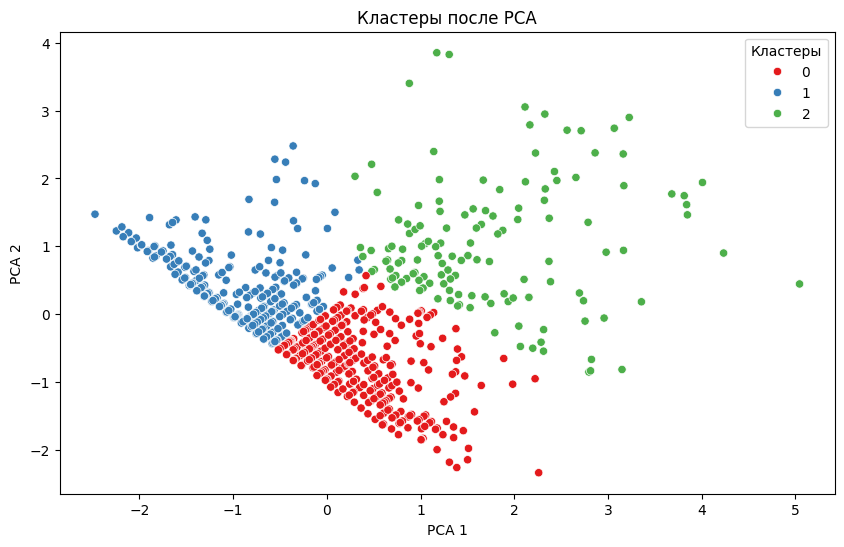

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

df = pd.read_csv("all_updated.csv")
df = df[["age", "net_worth"]].dropna()
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df = df.dropna(subset=["age"])
df["age"] = df["age"].astype(int)

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

df = remove_outliers(df, "age")
df = remove_outliers(df, "net_worth")

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

train_data, test_data = train_test_split(scaled_data, test_size=0.2, random_state=42)

class KMeans:
    def __init__(self, n_clusters, max_iters=300, tolerance=1e-4, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tolerance = tolerance
        self.random_state = random_state
        self.centroids = None

    def fit(self, X):
        np.random.seed(self.random_state)
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        
        for i in range(self.max_iters):
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            new_centroids = []
            for j in range(self.n_clusters):
                cluster_points = X[labels == j]
                cluster_mean = cluster_points.mean(axis=0)
                new_centroids.append(cluster_mean)
                
            new_centroids = np.array(new_centroids)
            change = np.linalg.norm(new_centroids - self.centroids)
            if change < self.tolerance:
                break

            self.centroids = new_centroids

        self.labels_ = labels

inertia = []
silhouette_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, max_iters=300, tolerance=1e-4)
    kmeans.fit(train_data)
    inertia.append(np.sum((train_data - kmeans.centroids[kmeans.labels_])**2))
    silhouette_scores.append(silhouette_score(train_data, kmeans.labels_))

optimal_k = cluster_range[np.argmax(silhouette_scores)]
kmeans_final = KMeans(n_clusters=optimal_k, max_iters=300, tolerance=1e-4)
kmeans_final.fit(scaled_data)
df["cluster"] = kmeans_final.labels_

final_silhouette = silhouette_score(scaled_data, df["cluster"])
print(f"Silhouette Score: {final_silhouette:.4f}")

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df["cluster"], palette="Set1")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Кластеры после PCA")
plt.legend(title="Кластеры")
plt.show()
